# Autorisasi Awal

Untuk memanggil file Google Drive pada Google Colab, harus dilakukan 'Mounting' terlebih dahulu untuk menghubungkan antara Google Drive dan Google Colab. Kemudian mengimpor semua library yang dibutuhkan untuk menjalankan kode.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [3]:
from shapely import geometry
from matplotlib import patches
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import skimage.io
import subprocess
import rasterio
import gdal
import json
import os

# Anotasi Bounding Box Untuk Format YOLO

Data citra satelit yang digunakan diperoleh secara gratis dari [SpaceNet-2: Building detection v2](https://spacenet.ai/spacenet-buildings-dataset-v2/). Data yang digunakan adalah citra 3-band (RGB) di wilayah Paris dan Khatoum beserta ground truth objek bangunan berupa poligon.

Ground truth poligon perlu dikonversi menjadi bentuk kotak yang sesuai dengan format YOLO. Kelas ```ImageRaster``` memiliki fungsi yang dapat digunakan untuk pemrosesan citra berekstensi GeoTIFF (citra 16-bit) dengan label ground truth GeoJSON, diantaranya fungsi convert poligon menjadi bounding box, generate titik koordinat bounding box, serta visualisasi gambar dengan hasil bounding box nya.

<div>
<img src="https://drive.google.com/uc?export=view&id=1Cnk-0g-2A62U_09-byF7foZO66HAryxL" width="500"/>
</div>

In [4]:
# path untuk path utama, path image, dan path ground truth
path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Paper/Data/"
geotif_path = os.path.join(path, "Geotiff/")
geojson_path = os.path.join(path, "GeoJSON/")
jpg = os.path.join(path, "Image JPG/")

In [5]:
class ImageRaster():
    # path data citra geotif dan label geojson
    geotif_path = jpg
    geojson_path = geojson_path

    def __init__(self, geojson, raster):
        self.raster_file = f"{self.geotif_path}{raster}"
        self.geospatial_file = f"{self.geojson_path}{geojson}"

        with open(self.geospatial_file) as src:
            self.fc = json.load(src)

        with rasterio.open(self.raster_file) as src:
            self.aff = src.transform
        self.ffa = ~self.aff

        self.jumlah_building = 0
        self.buildings = self.__get_box_buildings()

    def __get_box_buildings(self):
        """Get List of Box Buildings from Darknet geojson and tif file
        """
        return [self.__darknet_bb_from_feature(feat) for feat in self.fc['features']]

    def __darknet_bb_from_feature(self, feature):
        """Build a Darknet style bounding box from a geojson style feature
        """
        poly = geometry.shape(feature['geometry'])
        center = poly.centroid
        x_center, y_center = self.ffa * (center.x, center.y)
        bbox = poly.bounds
        width = (bbox[2] - bbox[0]) // self.aff[0]
        height = (bbox[3] - bbox[1]) // -self.aff[4]
        width_12 = width/2
        height_12 = height/2

        self.jumlah_building += 1
        return {"no" : f"building_{self.jumlah_building}",
               "height" : height,
               "width" : width,
               "x_center" : x_center,
               "y_center" : y_center,
               "kiri_bawah" : {"x" : x_center - width_12, "y" : y_center - height_12},
               "kanan_bawah" : {"x" : x_center + width_12, "y" : y_center - height_12},
               "kiri_atas" : {"x" : x_center - width_12, "y" : y_center + height_12},
               "kanan_atas" : {"x" : x_center + width_12, "y" : y_center + height_12},}

    def visualize_map(self, with_box = True, figsize=(10, 10), linewidth=3, edgecolor='y'):
        """Visualize map either with box of buildings or not
        """
        im = skimage.io.imread(self.raster_file)
        f, ax = plt.subplots(figsize=figsize)
        im = im/np.amax(im)
        im = np.clip(im, 0, 1)
        ax.imshow(im)
                
        if with_box:
            for building in self.buildings:
                patch = patches.Rectangle((building["kiri_bawah"]["x"], building["kiri_bawah"]["y"]), 
                                          building["width"], building["height"], linewidth=linewidth, 
                                          edgecolor=edgecolor, facecolor='none')
                ax.add_patch(patch)

Berikut merupakan contoh mendapatkan titik koordinat bounding box dari citra AOI-3 Paris beserta visualisasi hasilnya.

In [9]:
img1001 = ImageRaster('buildings_AOI_3_Paris_img1001.geojson', 'RGB-PanSharpen_AOI_3_Paris_img1001.jpg')
img1001.buildings

[{'height': 6.0,
  'kanan_atas': {'x': 115.82844466506504, 'y': 650.6357017420232},
  'kanan_bawah': {'x': 115.82844466506504, 'y': 644.6357017420232},
  'kiri_atas': {'x': 86.82844466506504, 'y': 650.6357017420232},
  'kiri_bawah': {'x': 86.82844466506504, 'y': 644.6357017420232},
  'no': 'building_1',
  'width': 29.0,
  'x_center': 101.32844466506504,
  'y_center': 647.6357017420232},
 {'height': 25.0,
  'kanan_atas': {'x': 500.2417078074068, 'y': 652.3448440395296},
  'kanan_bawah': {'x': 500.2417078074068, 'y': 627.3448440395296},
  'kiri_atas': {'x': 413.2417078074068, 'y': 652.3448440395296},
  'kiri_bawah': {'x': 413.2417078074068, 'y': 627.3448440395296},
  'no': 'building_2',
  'width': 87.0,
  'x_center': 456.7417078074068,
  'y_center': 639.8448440395296},
 {'height': 31.0,
  'kanan_atas': {'x': 86.71239462762605, 'y': 651.3681686781347},
  'kanan_bawah': {'x': 86.71239462762605, 'y': 620.3681686781347},
  'kiri_atas': {'x': 36.712394627626054, 'y': 651.3681686781347},
  'ki

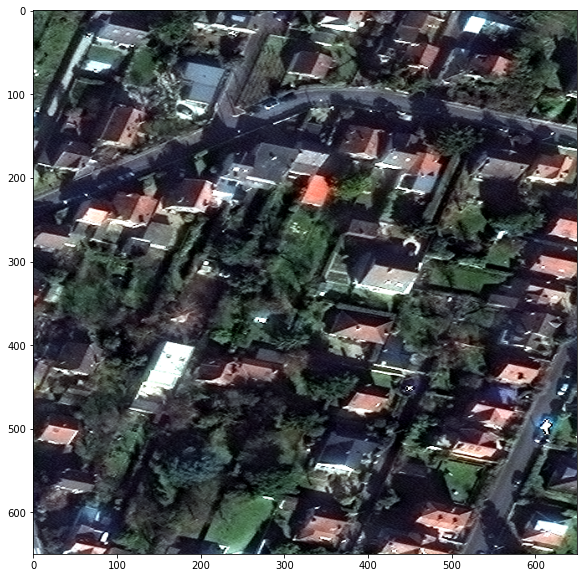

In [12]:
img1001.visualize_map(with_box=False)

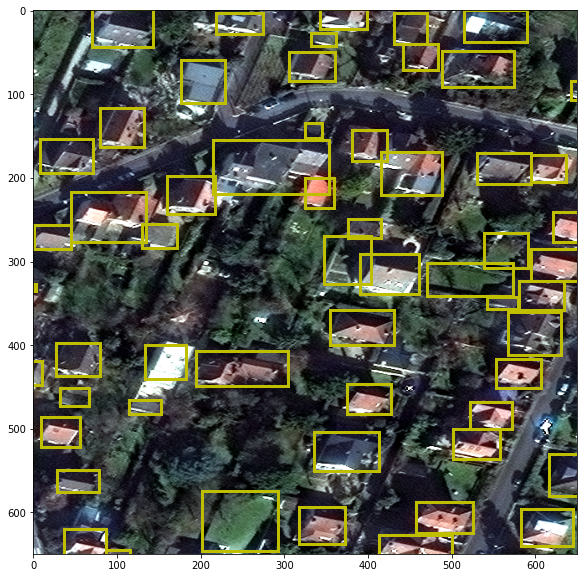

In [13]:
img1001.visualize_map()

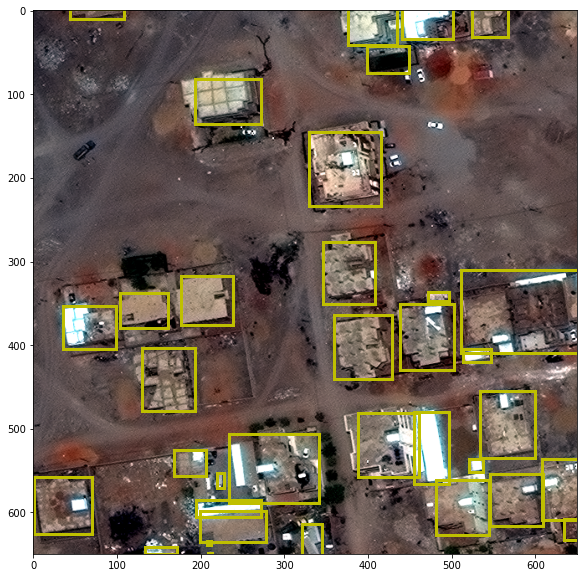

In [11]:
img971 = ImageRaster('buildings_AOI_5_Khartoum_img971.geojson', 'RGB-PanSharpen_AOI_5_Khartoum_img971.jpg')
img971.visualize_map()

# Data Preparation



## Membaca Nama File Citra dan Label pada Google Drive

Untuk melakukan konversi label, perlu dilakukan pembuatan kelas ```ImageRaster``` dengan parameter path dari masing-masing citra dan label. Sehingga nama file dari seluruh citra dan label perlu di-generate dan disimpan dalam sebuah array.

In [18]:
# Mengambil nama file dan memasukkan ke dalam array
geojson = []
geotif = []

for filename in os.listdir(geojson_path):
    if filename.endswith("geojson"):  
        #print(filename)
        geojson.append(filename)
for filename in os.listdir(geotif_path):
    if filename.endswith("tif"):  
        #print(filename)
        geotif.append(filename)

# mengurutkan nama file agar lebih mudah saat proses iterasi selanjutnya
geotif = sorted(geotif)
geojson = sorted(geojson)

#for i in range((len(geotif))):
  #print(geotif[i],geojson[i])

## Konversi Citra

Setiap citra terdiri dari pixel-pixel pembentuk gambar. Bit depth merupakan informasi jumlah warna yang ada pada setiap pixel. Semakin besar angka bit depth maka semakin banyak informasi warna yang tersedia pada tiap pixel sehingga dapat lebih merepresentasikan tonal warna semakin akurat. 

Citra GeoTIFF sebelumnya merupakan citra 16-bit, di mana rentang nilai nya dari 0 hingga 65.536. Sedangkan YOLO hanya mendukung citra 3-band dengan bit depth yakni 8 bit. Sehingga citra harus dikonversi ke bentuk 8-bit terlebih dahulu. Untuk memudahkan konversi citra dan label yang berjumlah 2.160, maka dilakukan iterasi untuk setiap file.

In [ ]:
# fungsi untuk konversi citra 16-bit ke 8-bit
def convert_to_8Bit(inputRaster, outputRaster,
                           outputPixType='Byte',
                           outputFormat='GTiff',
                           rescale_type='rescale',
                           percentiles=[2, 98]):
    '''
    Convert 16bit image to 8bit
    rescale_type = [clip, rescale]
        if clip, scaling is done strictly between 0 65535 
        if rescale, each band is rescaled to a min and max 
        set by percentiles
    '''
    srcRaster = gdal.Open(inputRaster)
    cmd = ['gdal_translate', '-ot', outputPixType, '-of', 
           outputFormat]
    
    # iterate through bands
    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        if rescale_type == 'rescale':
            bmin = band.GetMinimum()        
            bmax = band.GetMaximum()
            # if not exist minimum and maximum values
            if bmin is None or bmax is None:
                (bmin, bmax) = band.ComputeRasterMinMax(1)
            # else, rescale
            band_arr_tmp = band.ReadAsArray()
            bmin = np.percentile(band_arr_tmp.flatten(), 
                                 percentiles[0])
            bmax= np.percentile(band_arr_tmp.flatten(), 
                                percentiles[1])
        else:
            bmin, bmax = 0, 65535
        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(bmin))
        cmd.append('{}'.format(bmax))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))
    cmd.append(inputRaster)
    cmd.append(outputRaster)
    print ("Conversin command:", cmd)
    subprocess.call(cmd)

In [ ]:
jpg_path = os.path.join(path, "Image JPG")

# iterasi setiap file untuk konversi seluruh file citra
for tif in geotif:
  strg = tif.split(".tif")[0]
  arr = [strg]
  arr.append('.jpg')
  jpg = ''.join(arr)
  convert_to_8Bit(os.path.join(geotif_path, tif), os.path.join(jpg_path, jpg))

Conversin command: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-scale_1', '331.0', '582.0', '0', '255', '-scale_2', '502.0', '641.0', '0', '255', '-scale_3', '332.0', '433.0', '0', '255', '/content/drive/MyDrive/Colab Notebooks/Object Detection/Data/Geotiff/RGB-PanSharpen_AOI_5_Khartoum_img260.tif', '/content/drive/MyDrive/Colab Notebooks/Object Detection/Data/Image JPG/RGB-PanSharpen_AOI_5_Khartoum_img260.jpg']
Conversin command: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-scale_1', '313.0', '563.0', '0', '255', '-scale_2', '470.0', '625.0', '0', '255', '-scale_3', '324.0', '423.0', '0', '255', '/content/drive/MyDrive/Colab Notebooks/Object Detection/Data/Geotiff/RGB-PanSharpen_AOI_5_Khartoum_img250.tif', '/content/drive/MyDrive/Colab Notebooks/Object Detection/Data/Image JPG/RGB-PanSharpen_AOI_5_Khartoum_img250.jpg']
Conversin command: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-scale_1', '402.0', '630.0', '0', '255', '-scale_2', '506.0', '832.0', '0', '255', '

Berikut merupakan contoh visualisasi citra 8-bit yang telah dikonversi.

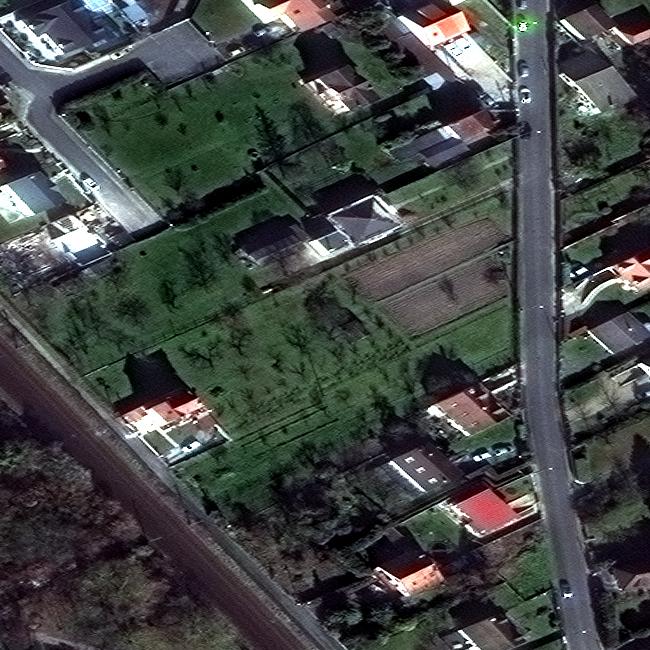

In [ ]:
Image.open(os.path.join(jpg_path, 'RGB-PanSharpen_AOI_3_Paris_img128.jpg'))

## Konversi Ground Truth Poligon ke Bounding Box

Object Detection melakukan deteksi suatu kelas menggunakan pendekatan berbasis objek. Misalnya pada kasus deteksi bangunan, tiap bangunan merupakan objek yang berbeda. Pada YOLO, objek dideteksi dengan cara melakukan prediksi bounding box pada seluruh objek yang ada pada citra. Sehingga ground truth yang berupa poligon harus dikonversi terlebih dahulu ke bentuk bounding box yang sesuai dengan format YOLO. 

Satu file TXT berisi label seluruh bangunan untuk 1 citra, satu baris pada file TXT merupakan label untuk satu bangunan. Anotasi label pada tiap baris adalah sebagai berikut. 

```
<class_id> <x_center/X> <y_center/Y> <width/X> <height/Y> 
```

di mana :
*   class_id : id dari kelas objek yang berbeda
*   x_center, y_center : titik koordinat center dari bounding box
*   width, height : lebar dan tinggi bounding box
*   X, Y : lebar dan tinggi dari citra


In [ ]:
# iterasi untuk konversi label pada citra yang bersesuaian dengan label
for i,j in zip(geotif, geojson):
  img = ImageRaster(j, i)
  obj = []
  for k in range(img.jumlah_building):
    arr = []
    X = 650
    Y = 650
    arr.extend(['0',img.buildings[k]['x_center']/X,
                    img.buildings[k]['y_center']/Y,
                    img.buildings[k]['width']/X,
                    img.buildings[k]['height']/Y])
    obj.append(arr)
  
  # menyimpan file label pada google drive
  my_string = i
  strg = my_string.split(".tif")[0]
  filename = f'/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Data/Label TXT/{strg}.txt'
  np.savetxt(filename, obj, fmt="%s")

## Seleksi Citra yang Memiliki Objek Bangunan

Citra yang digunakan untuk melatih model adalah citra yang memiliki objek bangunan. Untuk itu, dilakukan filter pada masing-masing file citra dan label yang bersesuaian dengan cara memeriksa isi file TXT. File TXT yang berukuran 0 byte menandakan tidak terdapat label bangunan, yang mengartikan bahwa pada citra dengan nama file yang bersesuaian tidak terdapat objek bangunan di dalamnya. 

In [ ]:
main_path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Paper/Data/"
txt_path = os.path.join(main_path, "Label TXT/")
jpg_path = os.path.join(main_path, "Image JPG/")

txtname = []
txt = []
jpg = []
jpg_filter = []

# seleksi nama file txt yang memiliki isi dalam file
for filename in os.listdir(txt_path):
  if filename.endswith("txt"):
    path = os.path.join(txt_path, filename)
    filesize = os.path.getsize(path)
    if filesize != 0:
      txt.append(filename)
      strg = filename.split(".txt")[0]
      txtname.append(strg)

for filename in os.listdir(jpg_path):
  if filename.endswith("jpg"):
    jpg.append(filename)

# mengambil nama file jpg yang bersesuaian dengan txt yang terseleksi sebelumnya
for jpgfile in jpg:
  jpgname = jpgfile.split(".jpg")[0]
  if jpgname in txtname:
    jpg_filter.append(jpgfile)

# array berupa nama file citra dan label yang terseleksi
txt = sorted(txt)
jpg_filter = sorted(jpg_filter)

In [ ]:
# periksa apakah urutan file citra telah bersesuaian dengan file label
for i in range(len(txt)):
  print(txt[i], jpg_filter[i])

RGB-PanSharpen_AOI_3_Paris_img100.txt RGB-PanSharpen_AOI_3_Paris_img100.jpg
RGB-PanSharpen_AOI_3_Paris_img1000.txt RGB-PanSharpen_AOI_3_Paris_img1000.jpg
RGB-PanSharpen_AOI_3_Paris_img1001.txt RGB-PanSharpen_AOI_3_Paris_img1001.jpg
RGB-PanSharpen_AOI_3_Paris_img1003.txt RGB-PanSharpen_AOI_3_Paris_img1003.jpg
RGB-PanSharpen_AOI_3_Paris_img1007.txt RGB-PanSharpen_AOI_3_Paris_img1007.jpg
RGB-PanSharpen_AOI_3_Paris_img1008.txt RGB-PanSharpen_AOI_3_Paris_img1008.jpg
RGB-PanSharpen_AOI_3_Paris_img1009.txt RGB-PanSharpen_AOI_3_Paris_img1009.jpg
RGB-PanSharpen_AOI_3_Paris_img101.txt RGB-PanSharpen_AOI_3_Paris_img101.jpg
RGB-PanSharpen_AOI_3_Paris_img1010.txt RGB-PanSharpen_AOI_3_Paris_img1010.jpg
RGB-PanSharpen_AOI_3_Paris_img1011.txt RGB-PanSharpen_AOI_3_Paris_img1011.jpg
RGB-PanSharpen_AOI_3_Paris_img1012.txt RGB-PanSharpen_AOI_3_Paris_img1012.jpg
RGB-PanSharpen_AOI_3_Paris_img1013.txt RGB-PanSharpen_AOI_3_Paris_img1013.jpg
RGB-PanSharpen_AOI_3_Paris_img1016.txt RGB-PanSharpen_AOI_3_Paris_im

# Memisahkan Data Latih & Tes

Data yang sudah disaring berdasarkan ada tidaknya objek bangunan pada citra kemudian dilakukan split untuk proses pelatihan dan pengujian. Data latih dan data tes masing-masing dipisah dengan proporsi sebesar 80% dan 20%

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(jpg_filter, txt, test_size=0.2, random_state=23)

x_train = sorted(x_train)
x_test = sorted(x_test)
y_train = sorted(y_train)
y_test = sorted(y_test)

# periksa apakah urutan jpg train dan txt train sudah sesuai
#for i in range(len(x_train)):
  #print(x_train[i], y_train[i])

# Kompresi File Citra dan Label ke Bentuk Zip

Untuk memudahkan pemindahan seluruh file ke dalam train model YOLO nantinya, maka terlebih dahulu dilakukan kompresi file. Seluruh file yang digunakan diletakkan ke dalam satu folder, kemudian folder tersebut dilakukan kompresi ke bentuk zip.

## Kompresi Data Latih & Tes

In [ ]:
import shutil

train_path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Data/train"
test_path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Data/test"

# copy seluruh file citra dan label sebagai data latih ke dalam folder train
for txt, jpg in zip(y_train, x_train):
  shutil.copy(os.path.join(txt_path, txt), train_path)
  shutil.copy(os.path.join(jpg_path, jpg), train_path)

# copy seluruh file citra dan label sebagai data tes ke dalam folder test
for txt, jpg in zip(y_test, x_test):
  shutil.copy(os.path.join(txt_path, txt), test_path)
  shutil.copy(os.path.join(jpg_path, jpg), test_path)

In [ ]:
# menjadikan folder data sebagai root
%cd ./drive/My Drive/ColabNotebooks/ObjectDetection/Paper/Data

/content/drive/My Drive/ColabNotebooks/ObjectDetection/Paper/Data


In [ ]:
!zip -r "train.zip" "train/"

  adding: train/ (stored 0%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img100.txt (deflated 65%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img100.jpg (deflated 19%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1000.txt (deflated 65%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1000.jpg (deflated 19%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1003.txt (deflated 65%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1003.jpg (deflated 23%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1007.txt (deflated 66%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1007.jpg (deflated 18%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1008.txt (deflated 64%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1008.jpg (deflated 19%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1009.txt (deflated 62%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img1009.jpg (deflated 29%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img101.txt (deflated 66%)
  adding: train/RGB-PanSharpen_AOI_3_Paris_img101.jpg (deflated 

In [ ]:
!zip -r "test.zip" "test/"

  adding: test/ (stored 0%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1001.txt (deflated 66%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1001.jpg (deflated 15%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1035.txt (deflated 47%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1035.jpg (deflated 23%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1036.txt (deflated 53%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1036.jpg (deflated 22%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1038.txt (deflated 63%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1038.jpg (deflated 18%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1041.txt (deflated 65%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1041.jpg (deflated 21%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1048.txt (deflated 65%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1048.jpg (deflated 18%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1050.txt (deflated 66%)
  adding: test/RGB-PanSharpen_AOI_3_Paris_img1050.jpg (deflated 20%)
  addi

## Kompresi Data Gabungan

In [ ]:
obj_path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Data/obj"

# copy seluruh file citra dan label ke dalam folder obj
for txt, jpg in zip(txt, jpg_filter):
  shutil.copy(os.path.join(txt_path, txt), obj_path)
  shutil.copy(os.path.join(jpg_path, jpg), obj_path)

In [ ]:
!zip -r "obj.zip" "obj/"

  adding: obj/ (stored 0%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img100.txt (deflated 65%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img100.jpg (deflated 19%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1000.txt (deflated 65%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1000.jpg (deflated 19%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1001.txt (deflated 66%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1001.jpg (deflated 15%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1003.txt (deflated 65%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1003.jpg (deflated 23%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1007.txt (deflated 66%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1007.jpg (deflated 18%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1008.txt (deflated 64%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1008.jpg (deflated 19%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1009.txt (deflated 62%)
  adding: obj/RGB-PanSharpen_AOI_3_Paris_img1009.jpg (deflated 29%)
  adding: obj/RGB-PanSh

# Tuning Anchors Box dengan K-Means

Anchors box merupakan salah satu hyperparameter penting yang dapat disesuaikan untuk meningkatkan kinerja model. Oleh karena itu, dalam pemodelan dilakukan tuning hyperparameter ini menggunakan ukuran anchors box yang diperoleh berdasarkan ukuran objek pada data latih menggunakan k-means clustering. Ukuran anchors box yang digunakan sebanyak 9. Sehingga cluster sebanyak 9 dan titik pusat tiap cluster akan digunakan untuk ukuran anchors box.


In [ ]:
def Convert(string):
    li = list(string.split(" "))
    return li

def GenerateSizeObject(wilayah):
  txt_path = "/content/drive/MyDrive/ColabNotebooks/ObjectDetection/Paper/Data/Label TXT"
  build_arr = []
  region = []
  for file in os.listdir(txt_path):
    if wilayah in file: 
      with open(os.path.join(txt_path, file),'r') as file:
        for string in file:
          line = Convert(string.strip('\n'))
          build_arr.append(line)
          region.append(wilayah)
  new_build_arr = np.array(build_arr)
  data = pd.DataFrame(new_build_arr)
  data.drop(data.columns[[0,1,2]], axis = 1, inplace = True)
  data.rename(columns = {3 : 'rel_width',
                         4 : 'rel_height'}, inplace = True)
  for column in data.columns:
    data[column] = pd.to_numeric(data[column])
  data["width"] = data['rel_width']*650
  data["height"] = data['rel_height']*650
  data["region"] = region
  return data

In [ ]:
paris = GenerateSizeObject("Paris")
khartoum = GenerateSizeObject("Khartoum")
join = pd.concat([paris, khartoum]).reset_index(drop = True)
join

rel_width  rel_height  width  height    region
0       0.073846    0.023077   48.0    15.0     Paris
1       0.103077    0.040000   67.0    26.0     Paris
2       0.066154    0.040000   43.0    26.0     Paris
3       0.250769    0.081538  163.0    53.0     Paris
4       0.084615    0.084615   55.0    55.0     Paris
...          ...         ...    ...     ...       ...
41606   0.281538    0.215385  183.0   140.0  Khartoum
41607   0.026154    0.041538   17.0    27.0  Khartoum
41608   0.246154    0.216923  160.0   141.0  Khartoum
41609   0.053846    0.009231   35.0     6.0  Khartoum
41610   0.058462    0.020000   38.0    13.0  Khartoum

[41611 rows x 5 columns]

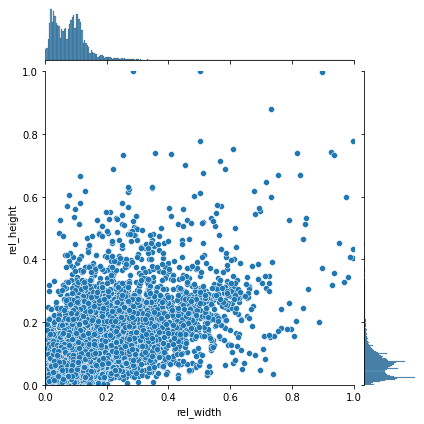

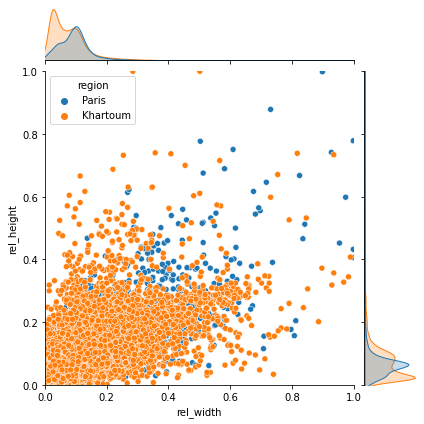

In [ ]:
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), data = join)
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), data = join, hue = 'region')

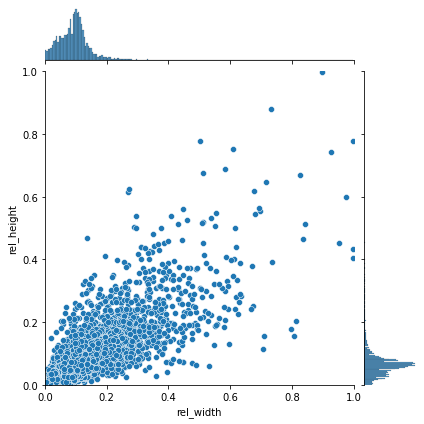

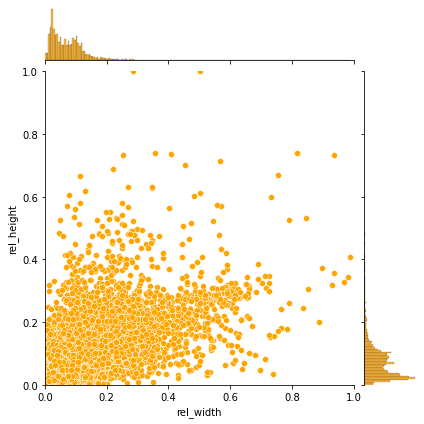

In [ ]:
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), data = paris)
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), color = 'orange', data = khartoum)

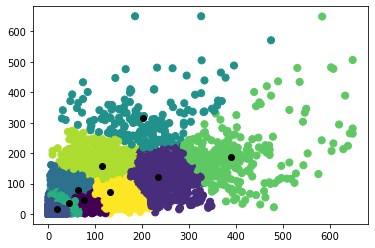

In [ ]:
X = join[['width', 'height']].values
K = KMeans(9, random_state=1000)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_, s=50, cmap='viridis')
plt.scatter(K.cluster_centers_[:, 0], K.cluster_centers_[:, 1], c='black');

In [ ]:
K.cluster_centers_

array([[ 75.31080399,  47.29990921],
       [232.89245983, 121.13720643],
       [ 18.02228186,  16.84085549],
       [ 63.98608137,  78.15717345],
       [201.21764706, 314.37058824],
       [ 44.939022  ,  36.61891202],
       [390.18770227, 186.14563107],
       [115.07384988, 157.23365617],
       [131.19852035,  71.28318948]])